In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.svm import LinearSVC
from sklearn.metrics import (accuracy_score, classification_report, 
                             ConfusionMatrixDisplay, roc_auc_score)

# 1. Load Data
data_path = '../diabetic_data.csv'
df = pd.read_csv(data_path)

# 2. Data Cleaning
df.replace('?', np.nan, inplace=True)
df.drop(columns=['weight', 'payer_code', 'medical_specialty', 'encounter_id', 'patient_nbr'], inplace=True)
df.dropna(subset=['diag_1', 'diag_2', 'diag_3', 'race'], inplace=True)
df['readmitted'] = df['readmitted'].replace({'>30': 1, '<30': 1, 'NO': 0})

# 3. Encoding
le = LabelEncoder()
for col in df.select_dtypes(include=['object']).columns:
    df[col] = le.fit_transform(df[col].astype(str))

# 4. Feature Selection & Scaling 
X = df.drop('readmitted', axis=1)
y = df['readmitted']

# Standardizing features: z = (x - u) / s
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 5. Split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

print(f"✅ SVM Environment Ready.")
print(f"Data has been scaled using StandardScaler to ensure distance-based logic works.")

C:\Users\dkshp\AppData\Local\Temp\ipykernel_16460\1123165698.py:24: Pandas4Warning: For backward compatibility, 'str' dtypes are included by select_dtypes when 'object' dtype is specified. This behavior is deprecated and will be removed in a future version. Explicitly pass 'str' to `include` to select them, or to `exclude` to remove them and silence this warning.
See https://pandas.pydata.org/docs/user_guide/migration-3-strings.html#string-migration-select-dtypes for details on how to write code that works with pandas 2 and 3.
  for col in df.select_dtypes(include=['object']).columns:


✅ SVM Environment Ready.
Data has been scaled using StandardScaler to ensure distance-based logic works.


In [ ]:
# 1. Initialize the Linear Support Vector Classifier

svm_model = LinearSVC(
    C=1.0, 
    class_weight='balanced', 
    random_state=42, 
    max_iter=5000, 
    dual=False
)

# 2. Training
print("🚀 Training SVM (Linear Kernel)... this may take a moment.")
svm_model.fit(X_train, y_train)

# 3. Generating Predictions
y_pred_svm = svm_model.predict(X_test)

# Note: calculated the 'decision function' scores for the ROC-AUC calculation.
y_scores_svm = svm_model.decision_function(X_test)

print("✅ SVM Training Complete.")

🚀 Training SVM (Linear Kernel)... this may take a moment.
✅ SVM Training Complete.


======= SVM (LINEAR KERNEL) EVALUATION =======
Accuracy Score: 0.6140
Area Under Curve (AUC): 0.6513

Classification Report:
              precision    recall  f1-score   support

           0       0.62      0.70      0.66     10468
           1       0.60      0.51      0.55      9143

    accuracy                           0.61     19611
   macro avg       0.61      0.61      0.61     19611
weighted avg       0.61      0.61      0.61     19611



C:\Users\dkshp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\utils\_plotting.py:176: FutureWarning: `**kwargs` is deprecated and will be removed in 1.9. Pass all matplotlib arguments to `curve_kwargs` as a dictionary instead.
  warnings.warn(


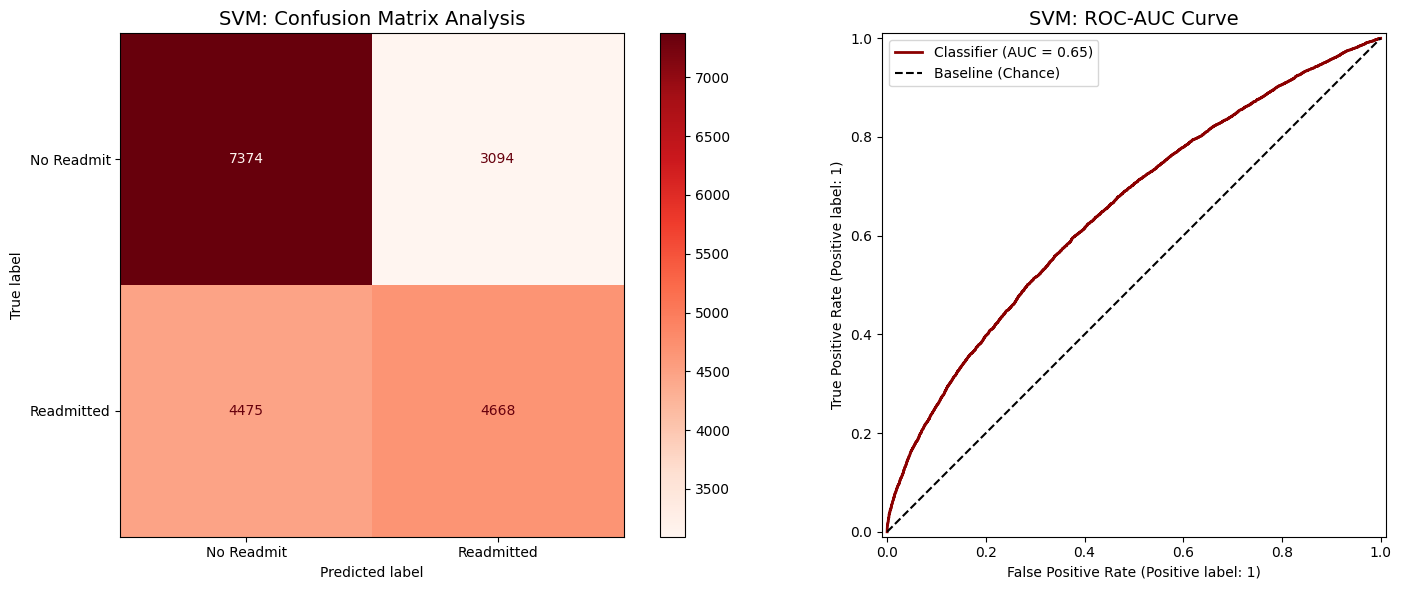

In [ ]:
from sklearn.metrics import RocCurveDisplay, ConfusionMatrixDisplay

# 1. Detailed Statistical Report
print("======= SVM (LINEAR KERNEL) EVALUATION =======")
print(f"Accuracy Score: {accuracy_score(y_test, y_pred_svm):.4f}")
print(f"Area Under Curve (AUC): {roc_auc_score(y_test, y_scores_svm):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_svm))

# 2. Setup the visualization area (1 row, 2 columns)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# 3. Confusion Matrix - Analysis of True Positives vs False Positives
ConfusionMatrixDisplay.from_predictions(
    y_test, 
    y_pred_svm, 
    display_labels=['No Readmit', 'Readmitted'],
    cmap='Reds',
    ax=ax1
)
ax1.set_title('SVM: Confusion Matrix Analysis', fontsize=14)

# 4. ROC Curve 
# Using y_scores_svm (distance from hyperplane) for the curve
RocCurveDisplay.from_predictions(
    y_test, 
    y_scores_svm, 
    ax=ax2,
    color='darkred',
    linewidth=2
)
ax2.plot([0, 1], [0, 1], 'k--', label='Baseline (Chance)') 
ax2.set_title('SVM: ROC-AUC Curve', fontsize=14)
ax2.legend()

plt.tight_layout()
plt.show()

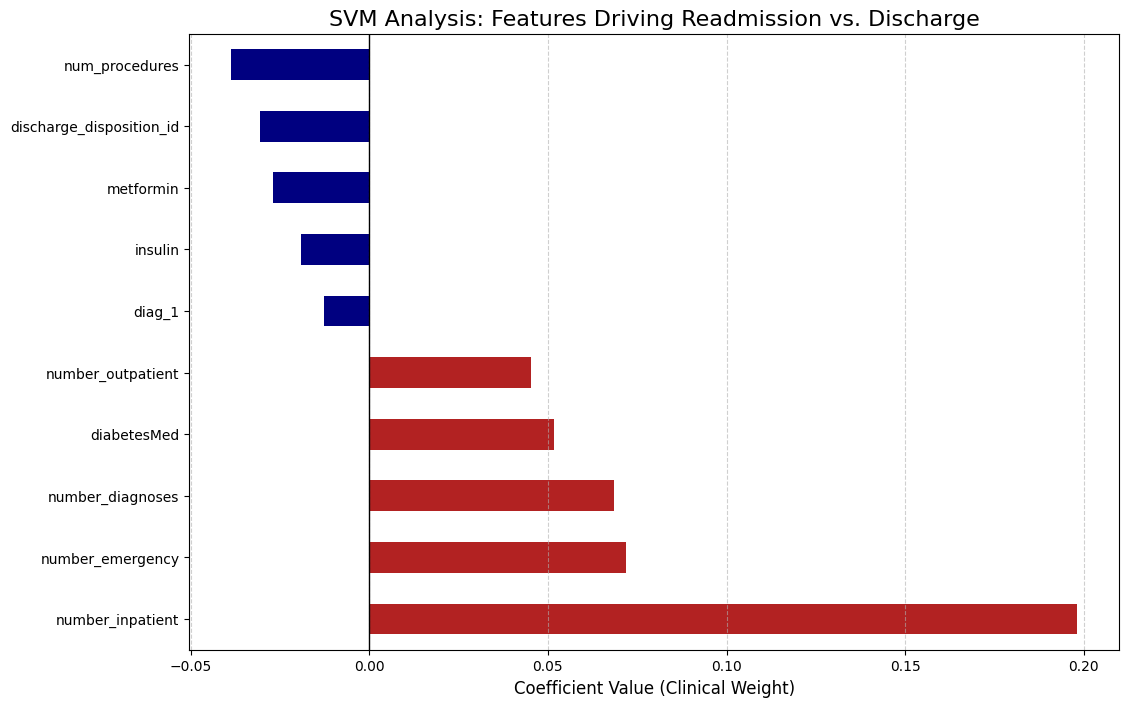

✅ Success! SVM analysis complete.
Strongest Predictor of Readmission: number_inpatient
Strongest Predictor of No-Readmission: num_procedures


In [ ]:
import os
from sklearn.metrics import precision_recall_fscore_support

# 1. Feature Importance (Coefficients)
coefs = svm_model.coef_.flatten()
feature_names = X.columns
feat_importances = pd.Series(coefs, index=feature_names).sort_values(ascending=False)

# 2. Visualization - We look at the top 5 and bottom 5 features to see what increases vs decreases risk
plt.figure(figsize=(12, 8))
top_and_bottom = pd.concat([feat_importances.head(5), feat_importances.tail(5)])
colors = ['firebrick' if x > 0 else 'navy' for x in top_and_bottom]
top_and_bottom.plot(kind='barh', color=colors)
plt.title('SVM Analysis: Features Driving Readmission vs. Discharge', fontsize=16)
plt.xlabel('Coefficient Value (Clinical Weight)', fontsize=12)
plt.axvline(0, color='black', lw=1)
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.show()

# 3. Save to Global Scoreboard

precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred_svm, average=None)
current_model_name = "SVM"
results_path = '../overall_results.csv'

new_result = pd.DataFrame({
    'Model': [current_model_name],
    'Accuracy': [accuracy_score(y_test, y_pred_svm)],
    'Recall_C1': [recall[1]], 
    'F1_Score': [f1[1]]
})

if not os.path.isfile(results_path):
    new_result.to_csv(results_path, index=False)
else:
    df_existing = pd.read_csv(results_path)
    # Filter out existing SVM entry to prevent duplicates
    df_existing = df_existing[df_existing['Model'] != current_model_name]
    pd.concat([df_existing, new_result], ignore_index=True).to_csv(results_path, index=False)

print(f"✅ Success! {current_model_name} analysis complete.")
print(f"Strongest Predictor of Readmission: {feat_importances.index[0]}")
print(f"Strongest Predictor of No-Readmission: {feat_importances.index[-1]}")